In [2]:
import argparse
from typing import Any, Dict
import os
import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader
from lightning.pytorch import Trainer, seed_everything
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint
from lightning.pytorch.loggers import MLFlowLogger
import matplotlib.pyplot as plt
import numpy as np
from utils import load_config
from model.AirDiffTraj import AirDiffTraj, AirDiffTrajDDPM
from utils.data_utils import TrafficDataset
from traffic.core import Traffic
from traffic.algorithms.generation import Generation
from sklearn.preprocessing import MinMaxScaler
from utils.condition_utils import load_conditions
from utils.helper import load_and_prepare_data, get_model
from evaluate import get_models, get_config_data
import argparse
import numpy as np
import lightning.pytorch as pl
import torch
from lightning.pytorch.loggers import MLFlowLogger
from lightning.pytorch import seed_everything
from utils.helper import load_and_prepare_data, get_model, save_config, load_config, init_config, init_model_config, get_model_train
from evaluate import get_models,reconstruct_and_plot, plot_traffics, compute_partial_mmd, get_mse_distribution
from train import setup_logger, get_dataloaders, train
from model.flow_matching import FlowMatching, Wrapper
from model.diffusion import Diffusion
from evaluation.similarity import compute_energy_distance
import os
from torch.utils.data import DataLoader, SubsetRandomSampler
from traffic.algorithms.generation import Generation
import numpy as np
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
from evaluation.diversity import data_diversity



checkpoint = f"artifacts/AirLatFMTraj_norm_landing_4/best_model.ckpt"
config_file = f"artifacts/AirLatFMTraj_norm_landing_4/config.yaml"
#artifact_location = args.artifact_location
#start_model = get_lowest_model_folder(artifact_location, args.model_name)

#checkpoint = f"{artifact_location}/{start_model}/best_model.ckpt"
#config_file = f"{artifact_location}/{start_model}/config.yaml"
config = load_config(config_file)
dataset_config = load_config("configs/dataset_landing_transfer.yaml")
#config = init_config(config, dataset_config, args, experiment = "test")

dataset_config["data_path"] = "/mnt/data/synthair/synthair_diffusion/data/resampled/combined_traffic_resampled_landing_200.pkl"
dataset, traffic = load_and_prepare_data(dataset_config)
   


(16170, 1) (16170, 1)
(16170, 1600)
(16170, 1600)
16170
torch.Size([])
['ADEP']
['ADES']
['cumdist']
torch.Size([16170, 1])
['day_of_week']
torch.Size([16170, 2])
['hour']
torch.Size([16170, 2])
['month']
torch.Size([16170, 2])
['runway']
['timedelta']
torch.Size([16170, 1])
Continuous conditions:  5
Categorical conditions:  3
(16170, 8)
Loading scaler from: /mnt/data/synthair/synthair_diffusion/data/resampled/scalers/4_datasets_con.gz
Scaler already exists at: /mnt/data/synthair/synthair_diffusion/data/resampled/scalers/4_datasets_con.gz
torch.Size([16170, 8]) torch.Size([16170, 3])
Scaler already exists at: /mnt/data/synthair/synthair_diffusion/data/resampled/scalers/4_datasets.gz


In [5]:
model_config = init_model_config(config, dataset_config, dataset)

print(dataset.data.shape)
print(dataset.con_conditions.shape, dataset.cat_conditions.shape)
print("Dataset loaded!")
print(f"*******model parameters: {model_config}")
train_config = config["train"]
train_config["devices"] = "cuda:0"
train_config["epochs"] = 100
config["logger"]["experiment_name"] = "transfer learning EIDW"
device = torch.device(f"cuda:0" if torch.cuda.is_available() else "cpu")
n = 1
#print(f"Training with {split} of the dataset...")
config["logger"]["tags"]['eval'] = "True"
#config["logger"]["tags"]['pretrained'] = "False"
#l_logger, run_name, artifact_location = setup_logger(args, config)
#l_logger.log_metrics({"split": split})

#checkpoint = f"{artifact_location}/{model_name}/best_model.ckpt"
model, trajectory_generation_model = get_models(config['model'], dataset.parameters, checkpoint, dataset.scaler, device)  

torch.Size([16170, 8, 200])
torch.Size([16170, 8]) torch.Size([16170, 3])
Dataset loaded!
*******model parameters: {'attn_resolutions': [32, 16], 'attr_dim': 32, 'ch': 64, 'ch_mult': [1, 2, 4, 4, 8], 'cnn': True, 'continuous_len': 8, 'data': {'batch_size': 64, 'conditional_features': {'ADEP': {'categories': ['00GA', '01FA', '02XS', '19GA', '22CO', '24PA', '25GA', '32PN', '38OI', '4GE2', '4OH4', '51GA', '60CO', '63OH', '6NJ9', '71KY', '78MI', '7CO3', '7PS7', '88PA', '89GE', '8KY6', '96CO', '98VA', 'AZ90', 'BIKF', 'BIRK', 'CCV4', 'CD14', 'CEF4', 'CFX8', 'CHF2', 'CNV9', 'CO56', 'CPR2', 'CT09', 'CT15', 'CT29', 'CYHU', 'CYKF', 'CYOW', 'CYQB', 'CYRO', 'CYUL', 'CYVR', 'CYYC', 'CYYT', 'CYYZ', 'DAAG', 'DAAX', 'DAOI', 'DTTA', 'EBAW', 'EBBR', 'EBCI', 'EBFS', 'EBKT', 'EBLG', 'EBMB', 'EBMO', 'EBOS', 'EDAM', 'EDAQ', 'EDAZ', 'EDDB', 'EDDC', 'EDDE', 'EDDF', 'EDDG', 'EDDH', 'EDDK', 'EDDL', 'EDDM', 'EDDN', 'EDDP', 'EDDR', 'EDDS', 'EDDT', 'EDDV', 'EDDW', 'EDFE', 'EDFH', 'EDFM', 'EDFQ', 'EDFZ', 'EDGS', 'E

Shapes: torch.Size([1, 8]) torch.Size([1, 3]) torch.Size([1, 8, 200])


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


torch.Size([1, 1, 256])
Reconstruction loss tensor(3.9411, device='cuda:0')
torch.Size([1, 3, 200]) torch.Size([1, 3, 200])
Median tensor(0.0015, device='cuda:0')
MSE: tensor(0.0143, device='cuda:0')
Data shape: (1, 8, 200)
Data shape: (1, 8, 200)


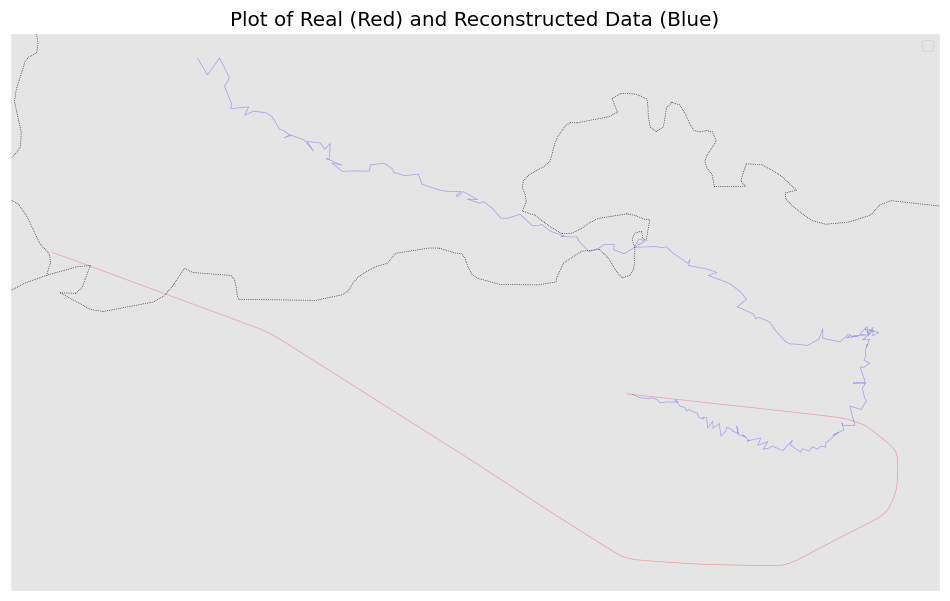

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


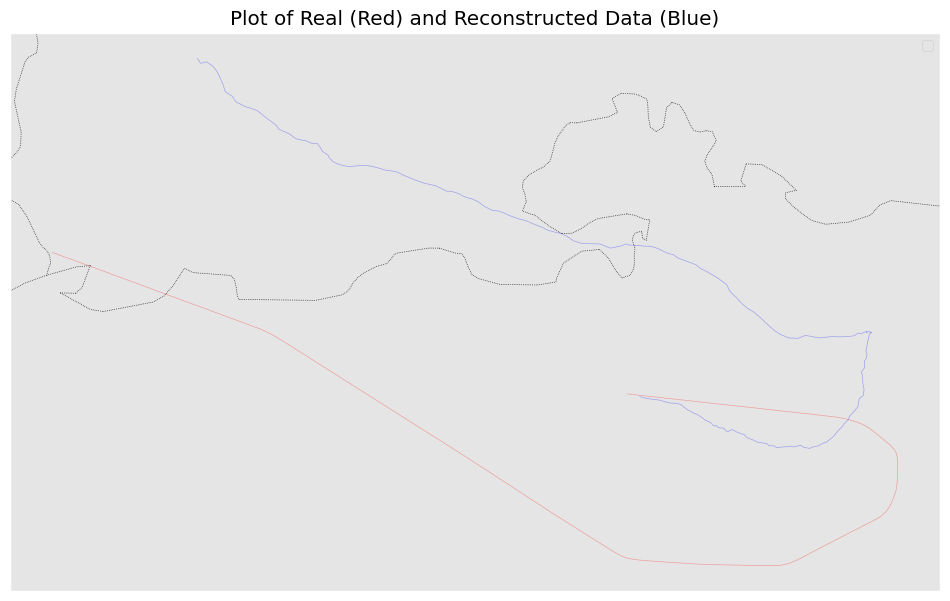

(10, 8, 200)


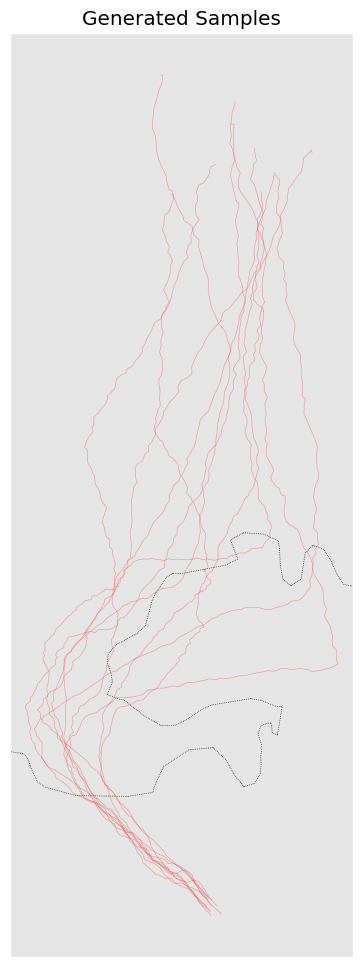

In [7]:
from evaluate import detach_to_tensor, get_traffic_from_tensor, exponentially_weighted_moving_average, plot_from_array
import pandas as pd
def local_eval(model, dataset, trajectory_generation_model, n, device):
    reconstructions, mse_dict, rnd, fig_0 = reconstruct_and_plot(dataset, model, trajectory_generation_model, n=n, d=device)
    plt.show()
    fig_smooth = plot_traffics([reconstructions[0],reconstructions[2]])
    plt.show()
    #n = 10
    n_samples = 10
    #logger.log_metrics({"n reconstructions": n, "n samples per" : n_samples})
    #length = config['data']['length']

    trajectory_generation_model = Generation(
        generation=model,
        features=dataset.parameters['features'],
        scaler=dataset.scaler,
    )
    
    rnd = np.random.randint(0, len(dataset), (n,))
    samples = []
    
    for i in rnd:
        # Load the i-th sample from the dataset
        x, con, cat, grid = dataset[i]
        con = con.reshape(1, -1).to("cuda")
        cat = cat.reshape(1, -1).to("cuda")
        grid = grid.reshape(1, -1).to("cuda")
        # Generate samples and steps using the model
        sample, _ = model.sample(n = n_samples, con = con, cat = cat, grid = grid)
        samples.append(sample)


    #samples, steps = generate_samples(dataset, model, rnd, n = n_samples, length = length)
    detached_samples = detach_to_tensor(samples).reshape(-1, len(dataset.features), 200)
    decoded = get_traffic_from_tensor(detached_samples, dataset, trajectory_generation_model, rnd)
    df = decoded.data
    numpy_array = exponentially_weighted_moving_average(df[['longitude', 'latitude', 'altitude']].to_numpy().reshape(-1, 200, 3))
    
    # Convert back to DataFrame
    df[['longitude', 'latitude', 'altitude']] = pd.DataFrame(numpy_array.reshape(-1,3), columns=['longitude', 'latitude', 'altitude'])
    decoded = Traffic(df)
    plot_from_array(decoded, "test")
    plt.show()
    #fig_smooth = plot_traffics([reconstructions[0],reconstructions[2]])
    """
    fig_mse_dict = get_mse_distribution(mse_dict)
    #cols = [ 'latitude', 'longitude', 'altitude', 'groundspeed']
    cols = [ 'latitude', 'longitude', 'altitude']
    subset1_data = reconstructions[0].data[cols].dropna().values
    #subset2_data = df_subset2[['latitude', 'longitude']].dropna().values
    subset2_data = reconstructions[2].data[cols].dropna().values
    #subset2_data = .data.dropna().values

    mmd, mmd_std = compute_partial_mmd(reconstructions[0],reconstructions[2] )
    # Compute energy distance between the raw trajectories
    energy_dist, edist_std = compute_energy_distance(subset1_data, subset2_data)    
    dtw, dtw_std, _ = compute_dtw_3d_batch(subset1_data, subset2_data)
    fig_pca = data_diversity(subset1_data, subset2_data, 'PCA', 'samples', model_name=model_name)
    fig_tsne = data_diversity(subset1_data, subset2_data, 't-SNE', 'samples', model_name = model_name)
    logger.experiment.log_figure(logger.run_id, fig_pca, f"figures/pca.png")
    logger.experiment.log_figure(logger.run_id, fig_tsne, f"figures/tsne.png")
    """
n = 1
local_eval(model, dataset, trajectory_generation_model, n, device)


In [17]:
X, con, cat, grid = dataset[:2]
x = X.to("cuda")
con = con.to("cuda")
cat = cat.to("cuda")
grid = grid.to("cuda")
z = model.vae.get_latent(x, con, cat, grid)
x_hat = model.vae.decode(z)
nn.functional.mse_loss(x, x_hat)

tensor(0.0011, device='cuda:0', grad_fn=<MseLossBackward0>)

In [20]:
z_hat = z.unsqueeze(1)
z_hat, _ = model.generative_model.reconstruct(z_hat, con, cat, grid)
z_hat = z_hat.squeeze(1)
nn.functional.mse_loss(z, z_hat)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [04:00<00:00,  4.15it/s]


tensor(4.9222e+08, device='cuda:0', grad_fn=<MseLossBackward0>)

In [21]:
batch = (z.unsqueeze(1), con, cat, grid)
loss = model.generative_model.training_step(batch, [])
loss

tensor(0.0079, device='cuda:0', grad_fn=<MseLossBackward0>)

In [31]:
#print("diff reconstruct", x.shape)
from tqdm import tqdm
steps = []
z_hat = z.unsqueeze(1)
with torch.no_grad():
    #Fix this
    #t = torch.tensor([model.generative_model.n_steps-1], device="cuda")
    t = torch.tensor([600], device="cuda")
    #print("t", t)
    x_t, noise = model.generative_model.q_xt_x0(z_hat, t)
    #print(z_hat, x_t)
    for i in tqdm(range(600, -1, -1)):
        x_t = model.generative_model.sample_step_ddim(x_t,con, cat,grid, i)
        if i % 200 == 0:
            steps.append(x_t.clone().detach())


z_hat_2 = x_t.squeeze(1)

nn.functional.mse_loss(z_hat, z_hat_2)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 601/601 [02:18<00:00,  4.33it/s]
/tmp/ipykernel_664814/1408486447.py:20: UserWarning: Using a target size (torch.Size([2, 128])) that is different to the input size (torch.Size([2, 1, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  nn.functional.mse_loss(z_hat, z_hat_2)


tensor(13.9968, device='cuda:0', grad_fn=<MseLossBackward0>)

In [33]:
x_hat = model.vae.decode(z_hat_2)
nn.functional.mse_loss(x, x_hat)

tensor(0.3692, device='cuda:0', grad_fn=<MseLossBackward0>)

In [41]:
h = model.vae.encoder(x)
q = model.vae.lsr(h)
z = q.rsample([1]).transpose(0, 1)
print(z.shape)
z.shape

torch.Size([2, 1, 128])


torch.Size([2, 1, 128])

In [3]:


np.random.seed(42)
model_name = "AirDiffTraj_5"

data_path = "data/resampled/combined_traffic_resampled_200.pkl"
artifact_location= "./artifacts"
checkpoint = f"./artifacts/{model_name}/best_model.ckpt"
config_file = f"./artifacts/{model_name}/config.yaml"

config = load_config(config_file)



#logger.experiment.log_dict(logger.run_id,config, config_file)
config, dataset, traffic, conditions = get_config_data(config_file, data_path, artifact_location)
config['model']["traj_length"] = dataset.parameters['seq_len']
config['model']["continuous_len"] = dataset.con_conditions.shape[1]
model, trajectory_generation_model = get_models(config["model"], dataset.parameters, checkpoint, dataset.scaler)
dataset_config = config["data"]
batch_size = dataset_config["batch_size"]
n = 100
n_samples = 4
#logger.log_metrics({"n reconstructions": n, "n samples per" : n_samples})



(15231, 1400)
File found - Loading from pickle
15231
torch.Size([6, 4, 5, 5])
(15231, 1400)
(91386, 4, 5, 5)
(91386, 100)
['cumdist']
torch.Size([15231, 1])
['day_of_week']
torch.Size([15231, 2])
['hour']
torch.Size([15231, 2])
['month']
torch.Size([15231, 2])
['timedelta']
torch.Size([15231, 1])
Continuous conditions:  5
Categorical conditions:  3
(15231, 8)
torch.Size([15231, 8]) torch.Size([15231, 3])
Model loaded with checkpoint!
Trajectory generation model created!


NameError: name 'reconstruct_and_plot' is not defined

In [27]:
n = 100
n_samples = 1

In [ ]:
from evaluate import reconstruct_and_plot
from evaluation.diversity import data_diversity
from evaluation.similarity import jensenshannon_distance
from evaluation.time_series import duration_and_speed, timeseries_plot
from evaluate import plot_traffic_comparison, generate_samples
reconstructions, mse, rnd, fig_0 = reconstruct_and_plot(dataset, model, trajectory_generation_model, n=n, model_name = model_name, rnd=None)
#logger.log_metrics({"Eval_MSE": mse})
#ogger.experiment.log_figure(logger.run_id,fig_0, f"figures/Eval_reconstruction.png")
#logger.experiment.log_figure(logger.run_id, fig, "figures/my_plot.png")
#print(reconstructions[1].data)
JSD, KL, e_distance, fig_1 = jensenshannon_distance(reconstructions[0].data, reconstructions[1].data, model_name = model_name)
#logger.log_metrics({"Eval_edistance": e_distance, "Eval_JSD": JSD, "Eval_KL": KL})
#logger.experiment.log_figure(logger.run_id, fig_1, f"figures/Eval_comparison.png")
#density(reconstructions, model_name = model_name)
fig_landing = plot_traffic_comparison(reconstructions, 2, f"./figures/{model_name}_", landing = True)
fig_takeoff = plot_traffic_comparison(reconstructions, 2, f"./figures/{model_name}_", landing = False)
#logger.experiment.log_figure(logger.run_id, fig_landing, f"figures/landing_comparison.png")
#logger.experiment.log_figure(logger.run_id, fig_takeoff, f"figures/takeoff_comparison.png")
length = config['data']['length']

samples, steps = generate_samples(dataset, model, rnd, n = n_samples, length = length)
#fig_99 = get_figure_from_sample_steps(steps, dataset, length)
#fig_99.savefig(f"./figures/{model_name}_generated_steps.png")
#logger.experiment.log_figure(logger.run_id, fig_99, f"figures/generated_steps.png")



Shapes: torch.Size([100, 8]) torch.Size([100, 3]) torch.Size([100, 7, 200])


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [06:22<00:00,  2.61it/s]


MSE: tensor(0.1321, device='cuda:0')
Data shape: (100, 7, 200)
Data shape: (100, 7, 200)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Energy Distance between the two subsets: 3.1823334588443553
KL Divergence between the two subsets: 0.22926447335672237
Jensen-Shannon Distance between the two subsets: 0.21504481141886125


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 88/100 [2:21:50<18:09, 90.79s/it]

In [ ]:
print(len(rnd))

In [16]:
from evaluate import detach_to_tensor
detached_samples = detach_to_tensor(samples).reshape(-1, len(dataset.features), length)
reco_x = detached_samples.transpose(0, 2, 1).reshape(detached_samples.shape[0], -1)
decoded = dataset.scaler.inverse_transform(reco_x)

(40, 1400) torch.Size([10, 7, 200])
(40, 200, 2) torch.Size([10, 200, 2])


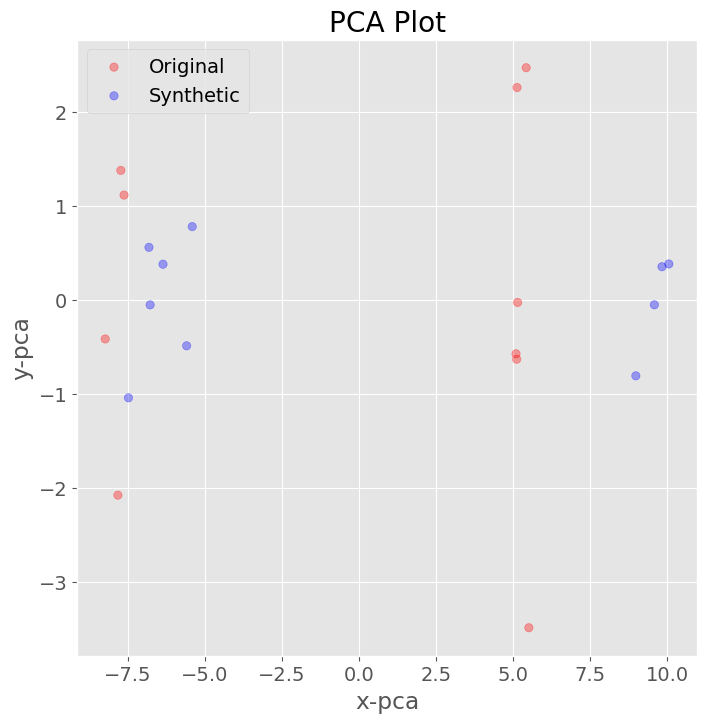

In [25]:
from sklearn.decomposition import PCA
def data_diversity(ori_data, generated_data, analysis, average_dimension='sequence', max_sample_size=1000, model_name='model'):
    """
    Data diversity assessment using PCA or t-SNE for original & synthetic distribution visualization.

    Inputs:
        - ori_data (array): original data
        - synthetic_data (array): synthetic data
        - analysis_type (str): PCA or t-SNE
        - average_dimension (string): flatten along 'sequence' or 'samples' dimension
        - max_sample_size (int): maximum sample size for computational speed
    """
    fig = plt.figure(figsize=(8, 8))
    plt.rcParams.update({'font.size': 14})
    
    # Determine the analysis sample size (minimum of 1000 or the length of the original data)
    anal_sample_no = min(max_sample_size, len(ori_data))

    # Randomly permute indices for data preprocessing
    idx = np.random.permutation(len(ori_data))[:anal_sample_no]

    # Convert original and generated data to numpy arrays and select a subset based on indices
    ori_data, generated_data = np.asarray(ori_data)[idx], np.asarray(generated_data)[idx]

    if average_dimension =='sequence':
        # Compute the mean along the sequence length dimension for both datasets
        prep_data = np.mean(ori_data[:, :, :], axis=1)
        prep_data_hat = np.mean(generated_data[:, :, :], axis=1)
    
    elif average_dimension =='samples':
        prep_data = np.mean(ori_data[:, :, :], axis=2)
        prep_data_hat = np.mean(generated_data[:, :, :], axis=2)
        
    else:
        prep_data = ori_data.reshape(ori_data.shape[0], -1)
        prep_data_hat = generated_data.reshape(generated_data.shape[0], -1)
            
    # Define colors for visualization (red for original, blue for synthetic)
    colors = ["red"] * anal_sample_no + ["blue"] * anal_sample_no

    # Perform analysis based on user choice (PCA or t-SNE)
    if analysis == 'PCA':
        # Apply PCA to both original and synthetic data
        pca_results = PCA(n_components=2).fit_transform(prep_data)
        pca_hat_results = PCA(n_components=2).fit_transform(prep_data_hat)

        # Plot PCA results
        plt.scatter(pca_results[:, 0], pca_results[:, 1], c=colors[:anal_sample_no], alpha=0.35, label="Original")
        plt.scatter(pca_hat_results[:, 0], pca_hat_results[:, 1], c=colors[anal_sample_no:], alpha=0.35, label="Synthetic")

    elif analysis == 't-SNE':
        # Combine preprocessed data for t-SNE analysis
        prep_data_final = np.concatenate((prep_data, prep_data_hat), axis=0)

        # Apply t-SNE to combined data
        tsne_results = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300).fit_transform(prep_data_final)

        # Plot t-SNE results
        plt.scatter(tsne_results[:anal_sample_no, 0], tsne_results[:anal_sample_no, 1], c=colors[:anal_sample_no], alpha=0.35, label="Original")
        plt.scatter(tsne_results[anal_sample_no:, 0], tsne_results[anal_sample_no:, 1], c=colors[anal_sample_no:], alpha=0.35, label="Synthetic")

    # Add legend and labels to the plot
    # plt.legend()
    plt.title('PCA Plot' if analysis == 'PCA' else 't-SNE Plot')
    plt.xlabel('x-pca' if analysis == 'PCA' else 'x-tsne')
    plt.ylabel('y-pca' if analysis == 'PCA' else 'y-tsne')
    plt.legend()
    #plt.savefig(f'./figures/{model_name}_diversity_{analysis}', dpi=400, bbox_inches='tight')
    return fig

print(decoded.shape, dataset[rnd][0].shape)
X = dataset[rnd][0].reshape(-1, length, len(dataset.features))[:,:,:2]
X_gen = decoded.reshape(-1, length, len(dataset.features))[:,:,:2]
print(X_gen.shape, X.shape)
fig_pca = data_diversity(X, X_gen, 'PCA', 'samples', model_name=model_name)
#fig_pca

# Sampling


In [ ]:
rnd = np.random.randint(0, len(dataset), (30))
def generate_samples(dataset, model, k=10, n=10, length=200):
    # Initialize lists to store results for each sample
    all_samples = []
    all_steps = []
    #print(rnd)
    for i in rnd:
        # Load the i-th sample from the dataset
        x, con, cat, grid = dataset[i]
        
        # Reshape con and cat as required
        con = con.reshape(1, -1)
        cat = cat.reshape(1, -1)
        
        # Adjust the shape of x
        #x = x.view(-1, 1, 28, 28)
        
        # Move grid to the device and adjust dimensions
        grid = grid.unsqueeze(dim=0).to("cuda")
        
        # Generate samples and steps using the model
        samples, steps = model.sample(n, con, cat, grid, length)
        
        # Append results to the lists
        all_samples.append(samples)
        all_steps.append(steps)
        
        # Print out shapes for verification (optional)
        print(f"Sample {i+1}:")
        #print("cat shape:", cat.shape)
        #print("grid shape:", grid.shape)
        #print("samples shape:", samples.shape)
        #print("steps length:", len(steps))
    
    return all_samples, all_steps


samples, steps = generate_samples(dataset, model, 30, 100)
#print(samples)
#print(samples.shape)
#print(len(steps))

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy
import traffic.core as tc  # Ensure the traffic library is installed

def detach_to_tensor(tensor_list):
    """
    Detaches each tensor in the list, moves to CPU, and stacks them into a single tensor.
    """
    return np.stack([tensor.cpu().detach() for tensor in tensor_list])

def plot_from_array(t):
    """
    Plots data from a traffic.core.Traffic object on a EuroPP projection.
    """
    plt.style.use("ggplot")
    fig = plt.figure(figsize=(12, 12))

    ax1 = fig.add_subplot(1, 1, 1, projection=ccrs.EuroPP())
    ax1.coastlines()
    t.plot(ax1, alpha=0.5, color="red", linewidth=1)
    ax1.add_feature(cartopy.feature.BORDERS, linestyle=":", alpha=1.0)
    plt.xlabel('X values')
    plt.ylabel('Y values')
    plt.title('Plot of X and Y Data from Array')
    plt.show()

# Assuming 'samples' is a list of tensors generated by model.sample
# Detach and stack samples into a single tensor
detached_samples = detach_to_tensor(samples).reshape(-1, 4, 200)

# Confirm detached_samples is a tensor and ready for use
print("Detached samples tensor shape:", detached_samples.shape)


In [ ]:
from traffic.algorithms.generation import Generation

trajectory_generation_model = Generation(
    generation=model,
    features=dataset.parameters['features'],
    scaler=dataset.scaler,
)

In [ ]:

reco_x = detached_samples.transpose(0, 2, 1).reshape(detached_samples.shape[0], -1)
decoded = dataset.scaler.inverse_transform(reco_x)
reconstructed_traf = trajectory_generation_model.build_traffic(
    decoded,
    coordinates=dict(latitude=48.5, longitude=8.4),
    forward=False,
)

In [ ]:
reconstructed_traf
plot_from_array(reconstructed_traf)

In [ ]:
from sklearn.manifold import TSNE 
from sklearn.decomposition import PCA  
import matplotlib.pyplot as plt 
import numpy as np  

def data_diversity(ori_data, generated_data, analysis, average_dimension='sequence', max_sample_size=1000):
    """
    Data diversity assessment using PCA or t-SNE for original & synthetic distribution visualization.

    Inputs:
        - ori_data (array): original data
        - synthetic_data (array): synthetic data
        - analysis_type (str): PCA or t-SNE
        - average_dimension (string): flatten along 'sequence' or 'samples' dimension
        - max_sample_size (int): maximum sample size for computational speed
    """
    plt.figure(figsize=(8, 8))
    plt.rcParams.update({'font.size': 14})
    
    # Determine the analysis sample size (minimum of 1000 or the length of the original data)
    anal_sample_no = min(max_sample_size, len(ori_data))

    # Randomly permute indices for data preprocessing
    idx = np.random.permutation(len(ori_data))[:anal_sample_no]

    # Convert original and generated data to numpy arrays and select a subset based on indices
    ori_data, generated_data = np.asarray(ori_data)[idx], np.asarray(generated_data)[idx]

    if average_dimension =='sequence':
        # Compute the mean along the sequence length dimension for both datasets
        prep_data = np.mean(ori_data[:, :, :], axis=1)
        prep_data_hat = np.mean(generated_data[:, :, :], axis=1)
    
    elif average_dimension =='samples':
        prep_data = np.mean(ori_data[:, :, :], axis=2)
        prep_data_hat = np.mean(generated_data[:, :, :], axis=2)
        
    else:
        prep_data = ori_data.reshape(ori_data.shape[0], -1)
        prep_data_hat = generated_data.reshape(generated_data.shape[0], -1)
            
    # Define colors for visualization (red for original, blue for synthetic)
    colors = ["red"] * anal_sample_no + ["blue"] * anal_sample_no

    # Perform analysis based on user choice (PCA or t-SNE)
    if analysis == 'PCA':
        # Apply PCA to both original and synthetic data
        pca_results = PCA(n_components=2).fit_transform(prep_data)
        pca_hat_results = PCA(n_components=2).fit_transform(prep_data_hat)

        # Plot PCA results
        plt.scatter(pca_results[:, 0], pca_results[:, 1], c=colors[:anal_sample_no], alpha=0.35, label="Original")
        plt.scatter(pca_hat_results[:, 0], pca_hat_results[:, 1], c=colors[anal_sample_no:], alpha=0.35, label="Synthetic")

    elif analysis == 't-SNE':
        # Combine preprocessed data for t-SNE analysis
        prep_data_final = np.concatenate((prep_data, prep_data_hat), axis=0)

        # Apply t-SNE to combined data
        tsne_results = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300).fit_transform(prep_data_final)

        # Plot t-SNE results
        plt.scatter(tsne_results[:anal_sample_no, 0], tsne_results[:anal_sample_no, 1], c=colors[:anal_sample_no], alpha=0.35, label="Original")
        plt.scatter(tsne_results[anal_sample_no:, 0], tsne_results[anal_sample_no:, 1], c=colors[anal_sample_no:], alpha=0.35, label="Synthetic")

    # Add legend and labels to the plot
    # plt.legend()
    plt.title('PCA Plot' if analysis == 'PCA' else 't-SNE Plot')
    plt.xlabel('x-pca' if analysis == 'PCA' else 'x-tsne')
    plt.ylabel('y-pca' if analysis == 'PCA' else 'y-tsne')
    plt.savefig('diversity', dpi=400, bbox_inches='tight')

    # Display the plot
    plt.show()

print(decoded.shape)
data_diversity(dataset[:3000][0][:,:2,:], reco_x.reshape(3000, 4, 200)[:,:2,:], 'PCA', 'sequence')
data_diversity(dataset[:3000][0][:,:2,:], reco_x.reshape(3000, 4, 200)[:,:2,:], 'PCA', 'samples')
data_diversity(dataset[:3000][0][:,:2,:], reco_x.reshape(3000, 4, 200)[:,:2,:], 'PCA')
data_diversity(dataset[:3000][0][:,:2,:], reco_x.reshape(3000, 4, 200)[:,:2,:], 't-SNE')

In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
def plot_from_array(data):
    # Check if the input data has the correct shape
    #if data.shape[1] != 2:
     #   raise ValueError("The second dimension of the array must have a size of 2 for x and y coordinates.")
    
  # Length of each x and y data series
    n = data.shape[0]
    plt.style.use("ggplot")
    fig = plt.figure(figsize=(10, 6))

    for i in range(n):
        y = data[i, :, 0]  # Extract the x values for the i-th series
        x = data[i, :, 1]  # Extract the y values for the i-th series
        
        plt.scatter(x, y, label=f'Series {i+1}')  # Plot each series with a label

    #ax1 = fig.add_subplot(1, 1, 1)
    #ax1.coastlines()
    #t.plot(ax1, alpha=0.1, color="red", linewidth=0.2)
    #ax1.add_feature(cartopy.feature.BORDERS, linestyle=":", alpha=1.0)
    plt.xlabel('X values')
    plt.ylabel('Y values')
    plt.title('Plot of X and Y Data from Array')
    plt.show()
    
scaler = dataset.scaler
#print(detached_s.shape)

detached_w = detached_s.transpose(0, 2, 1).reshape(detached_s.shape[0], -1)
detached_w = scaler.inverse_transform(detached_w).reshape(100, -1, 4)


print(detached_w.shape)

plot_from_array(detached_w[:1, :, :2])

In [ ]:
"""for i in steps:
    scaler = dataset.scaler
    i = i.cpu().numpy()
    #print(detached_s.shape)
    detached_w = i.transpose(0, 2, 1).reshape(i.shape[0], -1)
    detached_w = scaler.inverse_transform(detached_w).reshape(100, -1, 4)
    #print(detached_w.shape)
    
    plot_from_array(detached_w[:, :, :2])"""

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy
import traffic.core as tc
def plot_diffusion_steps(steps):
    """
    Plot images stored in a list side-by-side to visualize diffusion steps.
    
    Args:
        images (list): A list of images (each can be a 2D numpy array or a tensor) to be plotted.
    """
    n = len(steps)  # Number of images (or steps) in the diffusion process
    
    # Create subplots with 1 row and n columns
    fig, axes = plt.subplots(1, n, figsize=(20, 10))
    
    # If only one image is provided, make sure axes is iterable
    if n == 1:
        axes = [axes]
    
    # Plot each image in a subplot
    scaler = dataset.scaler
    for e, i in enumerate(steps):
        i = i.cpu().numpy()    
        detached_w = i.transpose(0, 2, 1).reshape(i.shape[0], -1)
        detached_w = scaler.inverse_transform(detached_w).reshape(i.shape[0], -1, 4)
        for p in range(n):
            y = detached_w[p, :, 0]  # Extract the x values for the i-th series
            x = detached_w[p, :, 1]  # Extract the y values for the i-th series
            axes[e].scatter(x, y, label=f'Series {i+1}')  # Plot each series with a label
            axes[e].axis('off')  # Turn off the axis for clarity
            axes[e].set_title(f"Step {i+1}")
    
    # Adjust the spacing between plots
    plt.tight_layout()
    plt.show()

plot_diffusion_steps(steps)

# Reconstruction

In [ ]:
n = 1000
rnd = np.random.randint(0, len(dataset), (n))
X2, con, cat, grid = dataset[rnd]
grid = grid.to("cuda")
X_ = X2.reshape(n, 4, -1).to("cuda")
con_ = con.reshape(n, -1)
cat_ = cat.reshape(n, -1)
print(con.shape, cat.shape, X_.shape)
#model.unet.guidance_scale = 3
x_rec, steps = model.reconstruct(X_, con_, cat_, grid)
#print(cat.unique(), con)

In [ ]:
print(X_.shape, x_rec.shape)
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy
import traffic.core as tc

In [ ]:
plt.style.use("ggplot")
fig = plt.figure(figsize=(12, 12))
ax1 = fig.add_subplot(1, 1, 1, projection=ccrs.EuroPP())
ax1.coastlines()
ax1.add_feature(cartopy.feature.BORDERS, linestyle=":", alpha=1.0)
plt.xlabel('X values')
plt.ylabel('Y values')
plt.title('Plot of X and Y Data from Array')
print("MSE",torch.nn.functional.mse_loss(X_, x_rec))
color = ["red", "blue"]
a = []
for c, i in enumerate([X_, x_rec]):
    print(i.cpu().numpy().shape)
    i = i.cpu().numpy()
    reco_x = i.transpose(0, 2, 1).reshape(i.shape[0], -1)
    decoded = dataset.scaler.inverse_transform(reco_x)
    reconstructed_traf = trajectory_generation_model.build_traffic(
    decoded.reshape(n, -1, 4),
    coordinates=dict(latitude=48.5, longitude=8.4),
    forward=False,
    )
    a.append(reconstructed_traf)
    #for i in range(n):
        #x = data[i, 0, :]  # Extract the x values for the i-th series
        #y = data[i, 1, :]  # Extract the y values for the i-th series
        
        #plt.scatter(x, y, label=f'Series {i+1}')  # Plot each series with a label


    reconstructed_traf.plot(ax1, alpha=0.5, color=color[c], linewidth=1)

plt.show()


In [ ]:
traj1 = X_.cpu()  # Shape (length, features)
traj2 = x_rec.cpu()  # Shape (length, features)

# Compute differences (could be absolute difference or any other metric)
differences = torch.abs(traj1 - traj2).mean(dim=1)  # Shape (length, features)
differences_max, _ = torch.abs(traj1 - traj2).max(dim=1)
differences_min, _ = torch.abs(traj1 - traj2).min(dim=1) 
print(differences.shape)
# Plot the differences for each feature over the length of the trajectory
plt.figure(figsize=(10, 6))

for i in range(3):
    name = ["longitude", "latitude", "altitude"]
    plt.plot(differences[i, :].numpy(), label=f'{name[i]}')

# Add labels and legend
plt.title('Feature-wise comparison between two trajectories MEAN')
plt.ylabel('Difference')
plt.legend()

# Display the plot
plt.show()

plt.figure(figsize=(10, 6))

for i in range(3):
    name = ["longitude", "latitude", "altitude"]
    plt.plot(differences_max[i, :].numpy(), label=f'{name[i]}')
    #plt.plot(differences_min[i, :].numpy(), label=f'{name[i]}')

# Add labels and legend
plt.title('Feature-wise comparison between two trajectories MAX')
plt.ylabel('Difference')
plt.legend()

# Display the plot
plt.show()

# Evaluation
## Density Distributions

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
from traffic.core import Traffic
training_trajectories_path = "./data/resampled/combined_traffic_resampled_200.pkl"
training_trajectories = Traffic.from_file(training_trajectories_path)
#synthetic_trajectories_path = "../data/synthetic_compare/OpenSky_EHAM_LIMC.pkl"
#synthetic_trajectories = Traffic.from_file(synthetic_trajectories_path)
synthetic_trajectories = a[1]


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pyproj import Geod
sns.set(style="whitegrid")

def get_flight_durations(traffic):
    durations = []
    for flight in traffic:
        duration = (flight.data['timestamp'].max() - flight.data['timestamp'].min()).total_seconds() / 60  # in minutes
        durations.append(duration)
    return np.array(durations)

def get_flight_speeds(traffic, method='calculate', remove_outliers=True, lower_quantile=0.01, upper_quantile=0.99):
    all_speeds = []
    geod = Geod(ellps="WGS84")
    
    for flight in traffic:
        if method == 'groundspeed' and 'groundspeed' in flight.data.columns:
            speeds = flight.data['groundspeed'].values
        elif method == 'calculate':
            coords = np.column_stack((flight.data['longitude'], flight.data['latitude']))
            times = flight.data['timestamp'].values
            
            distances = geod.inv(coords[:-1, 0], coords[:-1, 1], coords[1:, 0], coords[1:, 1])[2]
            time_diffs = np.diff(times).astype('timedelta64[s]').astype(float)
            
            # Filter out invalid or negative time differences
            valid_mask = (time_diffs > 0) & (distances >= 0)
            valid_distances = distances[valid_mask]
            valid_time_diffs = time_diffs[valid_mask]
            
            # Calculate speeds and convert to km/h
            speeds = valid_distances / valid_time_diffs * 3.6  
        else:
            raise ValueError("Method must be either 'groundspeed' or 'calculate'")
        
        # Remove zero speeds
        speeds = speeds[speeds > 0]
        
        all_speeds.extend(speeds)
    
    all_speeds = np.array(all_speeds)
    if remove_outliers:
        lower_bound = np.quantile(all_speeds, lower_quantile)
        upper_bound = np.quantile(all_speeds, upper_quantile)
        all_speeds = all_speeds[(all_speeds >= lower_bound) & (all_speeds <= upper_bound)]
    
    return all_speeds

training_durations = get_flight_durations(training_trajectories)
synthetic_durations = get_flight_durations(synthetic_trajectories)
print(training_trajectories)
print(training_trajectories[rnd])

small_training_trajectories = a[0]
small_synthetic_trajectories = a[1]

training_speeds = get_flight_speeds(small_training_trajectories, method='calculate')
synthetic_speeds = get_flight_speeds(small_synthetic_trajectories, method='calculate')

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Suppress specific UserWarnings related to set_xticklabels
warnings.filterwarnings("ignore", message=".*set_ticklabels.*")

# Set the style for a more professional look
sns.set_style("whitegrid")
sns.set_context("paper")

# Create a single figure with two rows and two columns
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Row 1: Flight Durations
sns.histplot(training_durations, kde=True, element="step", label='Real', color='#1f77b4', linewidth=1.5, ax=axes[0, 0])
sns.histplot(synthetic_durations, kde=True, element="step", label='Synthetic', color='#ff7f0e', linewidth=1.5, ax=axes[0, 0])
axes[0, 0].set_title('Flight Durations', fontsize=10)
axes[0, 0].set_xlabel('Duration (minutes)', fontsize=8)
axes[0, 0].set_ylabel('Density', fontsize=8)
axes[0, 0].legend(fontsize=6)
axes[0, 0].tick_params(labelsize=6)

sns.boxplot(data=[training_durations, synthetic_durations], palette=['#1f77b4', '#ff7f0e'], ax=axes[0, 1])
axes[0, 1].set_xticklabels(['Real', 'Synthetic'], fontsize=8)
axes[0, 1].set_title('Flight Durations', fontsize=10)
axes[0, 1].set_ylabel('Duration (minutes)', fontsize=8)
axes[0, 1].tick_params(labelsize=6)

# Row 2: Flight Speeds
sns.histplot(training_speeds, kde=True, element="step", label='Real', color='#1f77b4', linewidth=1.5, ax=axes[1, 0])
sns.histplot(synthetic_speeds, kde=True, element="step", label='Synthetic', color='#ff7f0e', linewidth=1.5, ax=axes[1, 0])
axes[1, 0].set_title('Flight Speeds', fontsize=10)
axes[1, 0].set_xlabel('Speed (km/h)', fontsize=8)
axes[1, 0].set_ylabel('Density', fontsize=8)
axes[1, 0].legend(fontsize=6)
axes[1, 0].tick_params(labelsize=6)

sns.boxplot(data=[training_speeds, synthetic_speeds], palette=['#1f77b4', '#ff7f0e'], ax=axes[1, 1])
axes[1, 1].set_xticklabels(['Real', 'Synthetic'], fontsize=8)
axes[1, 1].set_title('Flight Speeds', fontsize=10)
axes[1, 1].set_ylabel('Speed (km/h)', fontsize=8)
axes[1, 1].tick_params(labelsize=6)

# Adjust layout and remove top and right spines
plt.tight_layout()
for ax in axes.flatten():
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

# Add a main title for the entire figure
# fig.suptitle('Comparison of Real and Synthetic Flight Data', fontsize=12, y=1.02)

# Save the figure
#plt.savefig(f"../.figures/distribution_plots_{route_name}.png", bbox_inches='tight')
plt.show()

## Time Series

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from matplotlib.patches import Patch

def timeseries_plot(
    real_traffic,
    synthetic_traffic,
    features: list,
    units: dict,
    n_plot_samples: int = 1000,
    alpha: float = 0.3
):
    # Set the style for a more professional look
    sns.set(style="whitegrid")
    sns.set_context("paper")

    # Create subplots
    fig, axes = plt.subplots(2, len(features), figsize=(4 * len(features), 6), sharex=True)

    # Prepare data
    datasets = [real_traffic, synthetic_traffic]
    dataset_names = ['Real', 'Synthetic']
    colors = ['#1f77b4', '#ff7f0e']  # Specified colors

    for feature_idx, feature in enumerate(features):
        # Top row: individual trajectories
        for dataset_idx, (dataset, color) in enumerate(zip(datasets, colors)):
            feature_data = np.array([flight.data[feature].values for flight in dataset])
            sample_ind = np.random.randint(0, len(feature_data), min(n_plot_samples, len(feature_data)))
            for idx in sample_ind:
                axes[0, feature_idx].plot(feature_data[idx], alpha=alpha, color=color)

        axes[0, feature_idx].set_title(f"{feature.capitalize()}", fontsize=12)
        axes[0, feature_idx].tick_params(labelsize=10)
        axes[0, feature_idx].set_ylabel(f"{feature.capitalize()} ({units[feature]})", fontsize=12)

        # Bottom row: mean and confidence intervals
        for dataset_idx, (dataset, color) in enumerate(zip(datasets, colors)):
            feature_data = np.array([flight.data[feature].values for flight in dataset])
            mean_data = np.mean(feature_data, axis=0)
            std_data = np.std(feature_data, axis=0)

            axes[1, feature_idx].plot(mean_data, color=color, linewidth=2)

            t_value = stats.t.ppf(0.975, df=len(feature_data)-1)
            ci = t_value * std_data * np.sqrt(1 + 1/len(feature_data))
            axes[1, feature_idx].fill_between(
                range(len(mean_data)),
                mean_data - ci,
                mean_data + ci,
                color=color,
                alpha=0.2
            )

        axes[1, feature_idx].set_xlabel("Time Steps", fontsize=12)
        axes[1, feature_idx].set_ylabel(f"{feature.capitalize()} ({units[feature]})", fontsize=12)
        axes[1, feature_idx].tick_params(labelsize=10)

        # Remove top and right spines for both rows
        for row in range(2):
            axes[row, feature_idx].spines['top'].set_visible(False)
            axes[row, feature_idx].spines['right'].set_visible(False)

    # Create custom legend elements
    legend_elements = []
    for color, name in zip(colors, dataset_names):
        legend_elements.append(plt.Line2D([0], [0], color=color, lw=3, label=f'{name}'))
        legend_elements.append(Patch(facecolor=color, edgecolor=color, alpha=alpha, label=f'{name} 95% CI'))

    # Add a single legend for the entire figure
    fig.legend(handles=legend_elements, loc='upper center', ncol=2, fontsize=12, bbox_to_anchor=(0.5, 1.05))

    # Adjust layout
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    #plt.savefig(f"../.figures/timeseries_ci_{route_name}.png", bbox_inches='tight')
    plt.show()

# Usage
features_to_plot = ['latitude', 'longitude', 'altitude', 'timedelta']
units = {
    'latitude': '°',
    'longitude': '°',
    'altitude': 'ft',
    'timedelta': 's'
}

timeseries_plot(
    training_trajectories,
    synthetic_trajectories,
    features=features_to_plot,
    units=units
)

## Jensen-Shannon Distance

In [ ]:
import numpy as np
from scipy.stats import gaussian_kde
from scipy.special import rel_entr
from scipy.spatial.distance import jensenshannon
import matplotlib.pyplot as plt

# Assuming df_2 is a traffic.core.Traffic object containing trajectories
# Split the traffic object into two halves based on a criterion
df_subset1 = a[0]
df_subset2 = a[1]

# Convert the first subset to a DataFrame and extract lat/lon
subset1_data = df_subset1.data[['latitude', 'longitude']].dropna().values
subset2_data = df_subset2.data[['latitude', 'longitude']].dropna().values

# Kernel Density Estimation (KDE) for both subsets
kde_subset1 = gaussian_kde(subset1_data.T)
kde_subset2 = gaussian_kde(subset2_data.T)

# Create grid to evaluate KDEs over a common region (latitude, longitude)
xgrid, ygrid = np.mgrid[
    min(subset1_data[:, 0].min(), subset2_data[:, 0].min()):max(subset1_data[:, 0].max(), subset2_data[:, 0].max()):100j,
    min(subset1_data[:, 1].min(), subset2_data[:, 1].min()):max(subset1_data[:, 1].max(), subset2_data[:, 1].max()):100j
]

grid_coords = np.vstack([xgrid.ravel(), ygrid.ravel()])

# Evaluate the KDEs on the grid
subset1_density = kde_subset1(grid_coords).reshape(100, 100)
subset2_density = kde_subset2(grid_coords).reshape(100, 100)

# Normalize densities to ensure they sum to 1 (turn them into probabilities)
subset1_density /= np.sum(subset1_density)
subset2_density /= np.sum(subset2_density)

# Add a small constant to avoid zeros in the densities
epsilon = 1e-10
subset1_density += epsilon
subset2_density += epsilon

# Compute the average distribution M
M = 0.5 * (subset1_density + subset2_density)

# Calculate Jensen-Shannon distance using the scipy.spatial.distance.jensenshannon method
js_distance = jensenshannon(subset1_density.ravel(), subset2_density.ravel(), base=2)
kl_divergence = np.sum(rel_entr(subset1_density, subset2_density))

print(f"KL Divergence between the two subsets: {kl_divergence}")

print(f"Jensen-Shannon Distance between the two subsets: {js_distance}")

# Plotting the KDEs for comparison
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].imshow(subset1_density, origin='lower', cmap='Blues', extent=[xgrid.min(), xgrid.max(), ygrid.min(), ygrid.max()])
ax[0].set_title("Subset 1 Density")

ax[1].imshow(subset2_density, origin='lower', cmap='Reds', extent=[xgrid.min(), xgrid.max(), ygrid.min(), ygrid.max()])
ax[1].set_title("Subset 2 Density")

plt.tight_layout()
plt.show()

# Density

In [ ]:
import matplotlib.pyplot as plt

from matplotlib.offsetbox import AnchoredText
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from cartopy.crs import EuroPP, PlateCarree
from cartes.utils.features import countries, ocean


with plt.style.context("traffic"):

    fig = plt.figure(figsize=(15, 10), frameon=False)
    ax = fig.subplots(1, 2, subplot_kw=dict(projection=EuroPP()))

    for ax_ in ax:
        ax_.add_feature(countries(scale="10m", linewidth=1.5))

    vmax = None  # this trick will keep the same colorbar scale for both maps

    for i, data in enumerate([df_subset1, df_subset2]):
        # Aggregate and query the data, then convert to xarray
        data_xarray = data.agg_latlon(
            # 10 points per integer lat/lon
            resolution=dict(latitude=10, longitude=10),
            # count the number of flights
            flight_id="nunique"
        ).query(f"flight_id > 1").to_xarray()

        # Sort the DataArray by latitude and longitude
        data_xarray = data_xarray.sortby(['latitude', 'longitude'])

        # Plot the data using pcolormesh
        cax = data_xarray.flight_id.plot.pcolormesh(
            ax=ax[i],
            cmap="viridis",
            transform=PlateCarree(),
            vmax=vmax,
            add_colorbar=False,
        )

        cbaxes = inset_axes(ax[i], "4%", "60%", loc=3)
        cb = fig.colorbar(cax, cax=cbaxes)

        # Keep this value to scale the colorbar for the second day
        vmax = cb.vmax

        text = AnchoredText(
            f"{data.start_time:%B %d, %Y}",
            loc=1,
            prop={"size": 24, "fontname": "Ubuntu"},
            frameon=True,
        )
        text.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
        ax[i].add_artist(text)

    fig.set_tight_layout(True)

    plt.show()

## Length Error

In [ ]:
from geopy.distance import geodesic

def haversine(lat1, lon1,alt1, lat2, lon2, alt2):
    """
    Compute the great-circle distance between two points on the Earth's surface using their lat/lon values.
    Uses the geodesic method from the geopy library, which accounts for Earth's shape.
    
    Parameters:
    - lat1, lon1: Latitude and longitude of the first point
    - lat2, lon2: Latitude and longitude of the second point
    
    Returns:
    - Distance between the two points in meters.
    """
    return geodesic((lat1, lon1, alt1), (lat2, lon2, alt2)).meters


n = 100
X2, con, cat = dataset[:n]
X_ = X2.reshape(n, 4, -1).to("cuda")
con_ = con.reshape(n, -1)
cat_ = cat.reshape(n, -1)
print(con.shape, cat.shape, X_.shape)
model.unet.guidance_scale = 20
x_rec, steps = model.reconstruct(X_, con_, cat_)

In [ ]:
def build(X):
    x_rec = X.cpu().numpy()
    reco_x = x_rec.transpose(0, 2, 1).reshape(X.shape[0], -1)
    decoded = dataset.scaler.inverse_transform(reco_x)
    reconstructed_traf = trajectory_generation_model.build_traffic(
    decoded.reshape(n, -1, 4),
    coordinates=dict(latitude=48.5, longitude=8.4),
    forward=False,
    )
    return reconstructed_traf
X_ = build(X_)
x_rec = build(x_rec)